In [1]:
%matplotlib notebook

In [2]:
#!/usr/bin/env python

"""Learning a little about the distribution of spot intensities and their
errors."""

'Learning a little about the distribution of spot intensities and their\nerrors.'

# Exploring measurement errors on measured intensities in DIALS
###### 2018-06-08  Ben Williams

I basically don't know how DIALS handles errors, nor how the measured intensities from integrated diffraction spots are distributed.  Here goes...

### Imports

We'll want to pass in an unmerged MTZ file through `sys.argv`, so let's get `sys`.

In [3]:
import sys

`numpy` and `scipy.stats` are obvious useful modules.  In particular, from the latter, we will want to use `probplot()`.

In [4]:
import numpy as np
from scipy import stats as ss

From the CCTBX project, we'll want to use the MTZ file handling from `iotbx` and, of course, flex arrays from `cctbx`.

In [5]:
from iotbx import mtz
from cctbx.array_family import flex

Then, naturally, we'll want to make some pretty pictures.

In [6]:
from matplotlib import colors, pyplot as plt
from scipy import constants as sc

plt.rcParams.update({'font.size':5})

### Spoofing `sys.argv`

For demonstration purposes, let's drop an MTZ filepath into `sys.argv` so we can invoke the rest of this script without getting a `RuntimeError`.  The following cell is therefore included in this notebook, but doesn't beloong in the script proper.

In [7]:
sys.argv.pop()
sys.argv.pop()
sys.argv.append('/home/ekm22040/Software/mtz_learning/AUTOMATIC_DEFAULT_scaled_unmerged.mtz')
print(sys.argv)

['/home/ekm22040/DIALS/base/lib/python2.7/site-packages/ipykernel_launcher.py', '/home/ekm22040/Software/mtz_learning/AUTOMATIC_DEFAULT_scaled_unmerged.mtz']


### Extracting data from the MTZ file

The `mtz` module from `iotbx` allows us to create an MTZ object from the unmerged MTZ file.  A special `extract_miller_indices` method gives us access to the Miller indices as a flex array and the `columns` method creates a generator that yields `iotbx_ext_mtz.column` objects, which contain the data for a given column along with lots of other more or less useful methods not detailed here.

In addition to the Miller index values, herein assigned to `ind`, four data columns are extracted from the MTZ file for use later, namely the intensity of each spot, **I**, assigned to `I`; the measurement error on that intensity, **SIGI**, assigned to `sigI`; and the $x$ and $y$ coordinates of the detector plane, **XDET** and **YDET**, assigned to `x` and `y`.

In [8]:
def data_from_unmerged_mtz(filename):
  m = mtz.object(filename)  #Parse MTZ, with lots of useful methods.
  ind = m.extract_miller_indices()  #A flex array of Miller indices.
  cols = m.columns()  #Generates columns (augmented flex arrays).
  col_dict = {c.label(): c for c in cols}  #A dict of all the columns.
  
  I, sigI, x, y = (
    col_dict[label].extract_values().as_double()
    for label in ('I', 'SIGI', 'XDET', 'YDET')
  )
  
  return ind, I, sigI, x, y

### Merging spot intensities and measurement errors

For each symmetry-inequivalent Miller index $\mathbf{h}$, the merged spot intensity is calculated as a weighted mean 
$$\bar{I}_\mathbf{h} = \frac{\sum\limits_i w_i I_{\mathbf{h}\,i}}{\sum\limits_i w_i} \,\text,$$
where $w_i = \frac{1}{{\sigma_{\mathbf{h}\,i}}^2}$ is the weighting factor, $I_{\mathbf{h}\,i}$ is the intensity of a spot with symmetry-equivalent Miller index $\mathbf{h}$, $\sigma_{\mathbf{h}\,i}$ is the corresponding measurement error and $i$ enumerates all the different measured spots with symmetry equivalence for the given $\mathbf{h}$.  For clarity, from here onwards the index of summation will be dropped where it is unambiguous.

The corresponding unbiased weighted sample variance is calculated as
$${s_\mathbf{h}}^2 = \frac{1}{\sum w_i - \frac{\sum {w_i}^2}{\sum w_i}} \sum w_i \left( I_{\mathbf{h}\,i} - \bar{I}_\mathbf{h} \right)^2 \,\text.$$
The prefactor
$\left( \sum w_i - \frac{\sum {w_i}^2}{\sum w_i} \right)^{-1}$
is the weighted equivalent of Bessel's correction and, as in the unweighted case, is undefined when the number of measured symmetry-equivalent spots for a given Miller index (i.e. the multiplicity of observations) $N \equiv \sum\limits_i 1 = 1$.

We also calculate a measure of the uncertainty in the weighted mean, for which we use the standard deviation on the mean,
$$\sigma_\mathbf{h} = \sqrt{\frac{1}{\sum w_i}}\,\text.$$

$\bar{I}_\mathbf{h}$ is assigned to `Imeans`, $s_\mathbf{h}$ to `sImeans`, and $\sigma_\mathbf{h}$ to `stddevs`.  All are flex arrays with the same size as `ind`.  `multis` is a flex array with the same size as `int`, containing the multiplicities.

Naturally, there is a lot of redundant information in `ind`, `multis`, `Imeans`, `sImeans` and `stddevs`, since the entry for each symmetry-inequivalent Miller index is repeated $N$ times.  We retain the redundant information because it makes arithmentic manipulation with the un-averaged flex arrays `I` & `sigI` straightworward, and also allows us to plot things easily.  For convenience, `ind_unique` is a flex array containing just one entry of each of the symmetry-inequivalent Miller indices.  As such, it will always be true that `ind_unique.size()` $\le$ `ind.size()`.

In [9]:
def mean_error_stddev(ind, I, sigI):
  #Record the multiplicities.
  multis = flex.int([])
  
  #For weighted averaging.
  weights = 1 / flex.pow2(sigI)
  
  #Find unique Miller indices.
  ind_unique = flex.miller_index(np.unique(ind, axis=0))
  
  #Calculate the weighted mean intensities and the standard errors on them.
  sImeans = flex.double([])
  Imeans = flex.double([])
  
  #Calculate the standard deviations from unbiased weighted variances.
  stddevs = flex.double([])
  
  for hkl in ind_unique:
    sel = (ind == hkl).iselection()
    multi = sel.size()
    multis.extend(multi * flex.int(np.ones(multi).astype(np.uint32)))
    
    selI = I.select(sel)
    
    #Deal with multiplicity == 1 cases, for which variance is undefined.
    if multi == 1:
      Imeans.extend(selI)
      stddevs.extend(sigI.select(sel))
      sImeans.extend(sigI.select(sel))
    
    else:
      ones = flex.double(np.ones(multi).astype(np.float64))
      weight = weights.select(sel)
      sum_weight = flex.sum(weight)
      
      Imean = flex.sum(weight * selI) / sum_weight
      Imeans.extend(Imean * ones)
      
      stddev = 1 / flex.sqrt(sum_weight * ones)
      stddevs.extend(stddev)
      
      variance = (
        flex.sum(weight * flex.pow2(selI - Imean))
        / (sum_weight - flex.sum(flex.pow2(weight)) / sum_weight)
      )
      sImean = flex.sqrt(variance * ones)
      sImeans.extend(sImean)
  
  return ind_unique, multis, Imeans, sImeans, stddevs

Just to give an initial overview of the data, it might be informative to group reflections by symmetry-equivalent Miller index and plot them in chronological order.  This function does that, and also optionally plot the merged intensity ($\bar{I}_\mathbf{h}$) and a measure of spread (such as $s_\mathbf{h}$) if they are passed to `overlay` as a double of list-like objects.

In [10]:
def plot_time_series(ind, ind_unique, I, sigI, overlay=None):
  for hkl in ind_unique:
    sel = (ind == hkl).iselection()
    plt.errorbar(
      sel,
      I.select(sel),
      yerr=sigI.select(sel),
      ls="--"
    )
    if overlay:
      plt.errorbar(
        sel,
        overlay[0].select(sel),
        yerr = overlay[1].select(sel),
        ls = "-",
        color = "k",
        lw = .5
      )

Now we want to generate a normal probability plot.  It would also be informative to plot the deviation from a $1:1$ relationship between ordered responses and ordered statistic medians, as a mapping from multiplicity of observations and as a function of detector position.

In [11]:
def probplots(I, Imeans, error, multis, x, y):
  z = (I - Imeans) / error
  order = flex.sort_permutation(z)
  osm, osr = ss.probplot(z, fit=False)
  
  fig = plt.figure(figsize=6*np.array([sc.golden, 1]))
  
  extreme = np.ceil(np.abs(osr - osm).max())
  norm = colors.SymLogNorm(
    vmin = -extreme, vmax = extreme,
    linthresh = .02, linscale=1,
  )
  cmap_kws = {'cmap' : 'coolwarm_r', 'norm' : norm}
  
  ax1 = fig.add_subplot(221)
  ax1.set_title('Normal probability plot')
  ax1.set_xlabel('Order statistic medians, $m$')
  ax1.set_ylabel(
    'Ordered responses, $z_i$'
  )
  ax1.plot(osm, osr, '.b', ms=.5)
  ax1.plot([-5,5], [-5,5], '-g')
  
  ax2 = fig.add_subplot(223)
  ax2.set_title(
    'Difference between ordered responses and order statistic medians'
  )
  ax2.set_xlabel('Multiplicity')
  ax2.set_ylabel(
    '$z_i - m$'
  )
  ax2.plot(multis.select(order), osr - osm, '.', ms=.5)

  ax3 = fig.add_subplot(122)
  ax3.set_title(
    'Difference between ordered responses and order statistic medians'
  )
  ax3.set_xlabel('Detector $x$ position (pixels)')
  ax3.set_ylabel('Detector $y$ position (pixels)')
  ax3.set_aspect('equal', 'box')
  det_map = ax3.scatter(
    x.select(order),
    y.select(order),
    c = osr - osm,
    marker = ',',
    s = .5,
    **cmap_kws
  )
  cbar = fig.colorbar(det_map, ax=ax3, **cmap_kws)
  
  return osm, osr, order, fig

### A high-multiplicity test case

Now let's get some data from a high-multiplicity example from Graeme (origin unknown...), plot it up and take a look, using $s_\mathbf{h}$ as our measure of the error to normalise the intensities (i.e. examine the distribution of $z_i = \frac{I_{\mathbf{h}\,i} - \bar{I}_\mathbf{h}}{s_\mathbf{h}}$).

We'll ignore multiplicity-1 data.  OK, we could have saved ourselves the trouble of making sure that we defined all the arrays to include multiplicity-1 data in the first place, but it doesn't cost us too much to select them out here.

In [12]:
ind, I, sigI, x, y = data_from_unmerged_mtz(
  sys.argv[1] # Give an unmerged MTZ file as an argument.
)

#plot_time_series(ind, ind_unique, I, sigI)
#plt.show()

ind_unique, multis, Imeans, sImeans, stddevs = mean_error_stddev(
  ind, I, sigI
)

#plot_time_series(ind, ind_unique, I, sigI, overlay=(Imeans, stddevs))
#plt.show()  

# Select out multiplicity-1 data:
sel = (multis > 1).iselection()
I, sigI, Imeans, stddevs, sImeans, multis, x, y = map(
  lambda x: x.select(sel),
  (I, sigI, Imeans, stddevs, sImeans, multis, x, y)
)

And make the plots.

<IPython.core.display.Javascript object>


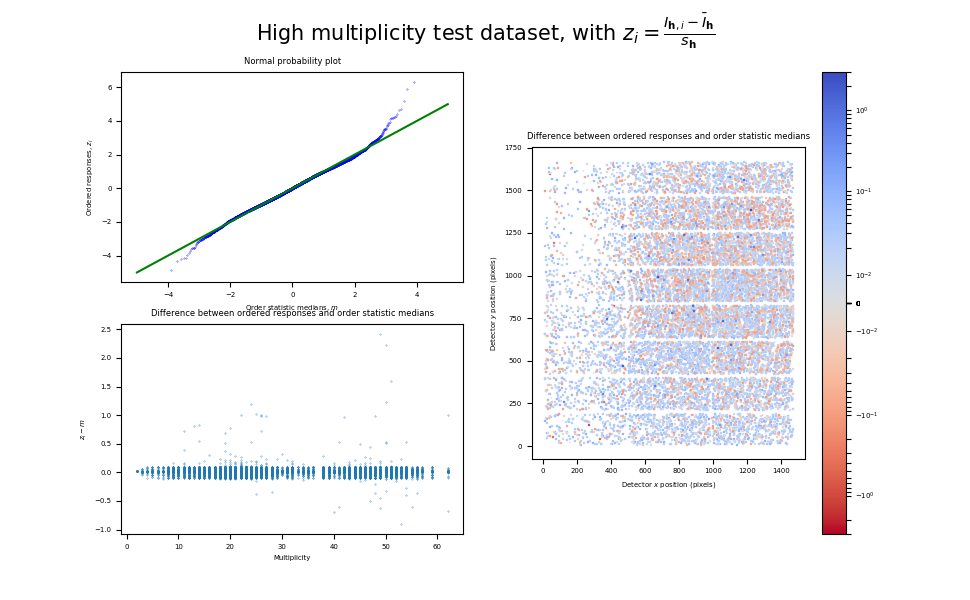

In [13]:
osm, osr, order, fig = probplots(I, Imeans, sImeans, multis, x, y)
fig.suptitle(
  r'High multiplicity test dataset, with $z_i = \frac{I_{\mathbf{h}, i} - \bar{I}_\mathbf{h}}{s_\mathbf{h}}$',
  fontsize = 15,
)
plt.show()

### A second (low-multiplicity) test dataset

Now, let's try it with a different dataset.  We'll use `/dls/i19-1/data/2018/sw18669-7/processed/a-2/1/DataFiles/AUTOMATIC_DEFAULT_scaled_unmerged.mtz`, saved in this directory as `AUTOMATIC_DEFAULT_scaled_unmerged.mtz`, and again we'll use $s_\mathbf{h}$ as our measure of error.

First, we'll spoof `sys.argv` again:

In [14]:
sys.argv.pop()
sys.argv.append(
  #'/dls/i19-1/data/2018/sw18669-7/processed/a-2/1/DataFiles/' +
  'AUTOMATIC_DEFAULT_scaled_unmerged.mtz'
)
print(sys.argv)

['/home/ekm22040/DIALS/base/lib/python2.7/site-packages/ipykernel_launcher.py', 'AUTOMATIC_DEFAULT_scaled_unmerged.mtz']


Now we read in the MTZ file again and select out the multiplicity-1 data.

In [15]:
ind, I, sigI, x, y = data_from_unmerged_mtz(
  sys.argv[1] # Give an unmerged MTZ file as an argument.
)

#plot_time_series(ind, ind_unique, I, sigI)
#plt.show()

ind_unique, multis, Imeans, sImeans, stddevs = mean_error_stddev(
  ind, I, sigI
)

#plot_time_series(ind, ind_unique, I, sigI, overlay=(Imeans, stddevs))
#plt.show()  

# Select out multiplicity-1 data:
sel = (multis > 1).iselection()
I, sigI, Imeans, stddevs, sImeans, multis, x, y = map(
  lambda x: x.select(sel),
  (I, sigI, Imeans, stddevs, sImeans, multis, x, y)
)

And plot.

<IPython.core.display.Javascript object>


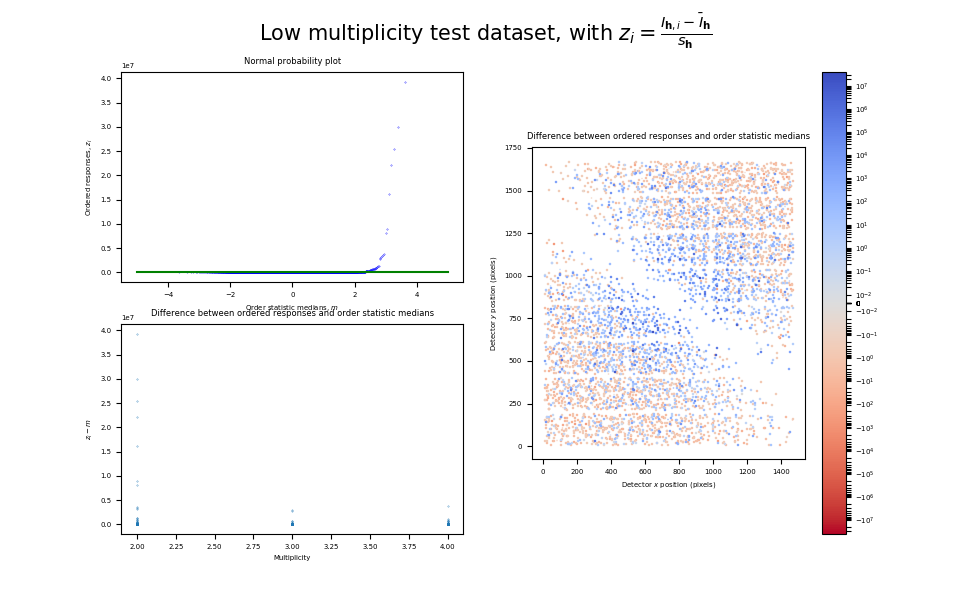

In [16]:
osm, osr, order, fig = probplots(I, Imeans, sImeans, multis, x, y)
fig.suptitle(
  r'Low multiplicity test dataset, with $z_i = \frac{I_{\mathbf{h}, i} - \bar{I}_\mathbf{h}}{s_\mathbf{h}}$',
  fontsize = 15,
)
plt.show()

Ooh er, that looks a bit funky.  Graeme suggests that using $s_\mathbf{h}$ as a measure of spread may be causing trouble in the value of $z$ — the prefactor $\left( \sum w_i - \frac{\sum {w_i}^2}{\sum w_i} \right)^{-1}$ in $s_\mathbf{h}$ is causing small fluctuations to be amplified at low multiplicities, where the averaging is poorer.

### A slightly different approach

A better (and simpler) way of doing things would be to use $\sigma_{\mathbf{h}\,i}$ in place of $s_\mathbf{h}$ in creating normalised intensities, i.e. use
$$z_i = \frac{I_{\mathbf{h}\,i} - \bar{I}_\mathbf{h}}{\sigma_{\mathbf{h}\,i}}\,\text.$$

#### High-multiplicity test case

Let's try it first for our original high-multiplicity dataset first.  First, we'll have to appropriately spoof `sys.argv` again.

In [17]:
sys.argv.pop()
sys.argv.append('/home/ekm22040/Software/mtz_learning/AUTOMATIC_DEFAULT_scaled_unmerged.mtz')
print(sys.argv)

['/home/ekm22040/DIALS/base/lib/python2.7/site-packages/ipykernel_launcher.py', '/home/ekm22040/Software/mtz_learning/AUTOMATIC_DEFAULT_scaled_unmerged.mtz']


And now we need to read in the data, select out the multiplicity-1 data...

In [18]:
ind, I, sigI, x, y = data_from_unmerged_mtz(
  sys.argv[1] # Give an unmerged MTZ file as an argument.
)

#plot_time_series(ind, ind_unique, I, sigI)
#plt.show()

ind_unique, multis, Imeans, sImeans, stddevs = mean_error_stddev(
  ind, I, sigI
)

#plot_time_series(ind, ind_unique, I, sigI, overlay=(Imeans, stddevs))
#plt.show()  

# Select out multiplicity-1 data:
sel = (multis > 1).iselection()
I, sigI, Imeans, stddevs, sImeans, multis, x, y = map(
  lambda x: x.select(sel),
  (I, sigI, Imeans, stddevs, sImeans, multis, x, y)
)

... and plot, this time with $z_i = \frac{\bar{I}_\mathbf{h} - I_{\mathbf{h}\,i}}{\sigma_{\mathbf{h}\,i}}$.

<IPython.core.display.Javascript object>


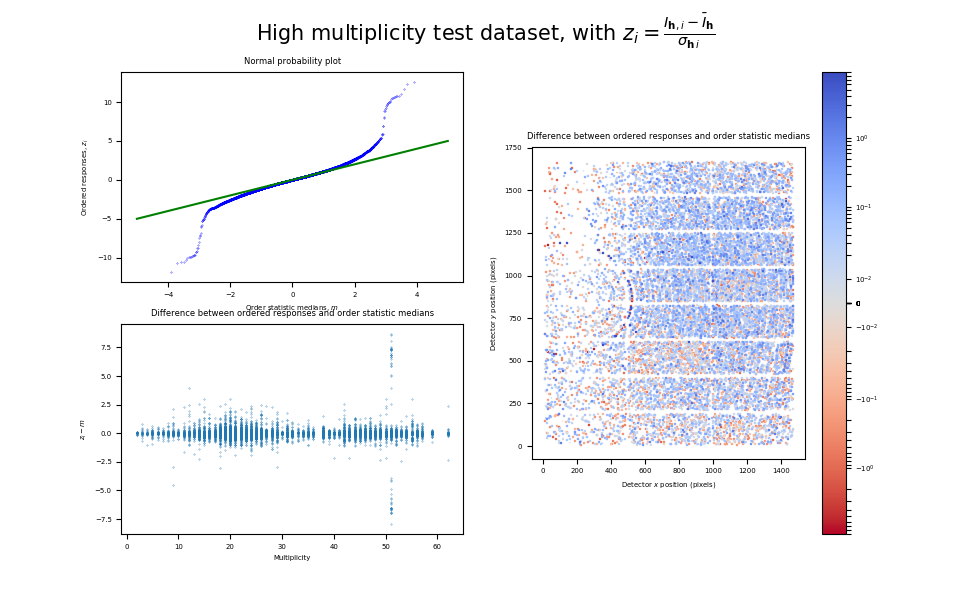

In [19]:
osm, osr, order, fig = probplots(I, Imeans, sigI, multis, x, y)
fig.suptitle(
  r'High multiplicity test dataset, with $z_i = \frac{I_{\mathbf{h}, i} - \bar{I}_\mathbf{h}}{\sigma_{\mathbf{h}\,i}}$',
  fontsize = 15,
)
plt.show()

That looks more believable and more informative.  Is that a ring of dodgy peaks due to masking of a powder ring or something?  Presumably, that also accounts for the big spread in values for multiplicity of 51.  Just out of interest, let's look at the same data with multiplicity-51 points excluded.

In [20]:
ind, I, sigI, x, y = data_from_unmerged_mtz(
  sys.argv[1] # Give an unmerged MTZ file as an argument.
)

#plot_time_series(ind, ind_unique, I, sigI)
#plt.show()

ind_unique, multis, Imeans, sImeans, stddevs = mean_error_stddev(
  ind, I, sigI
)

#plot_time_series(ind, ind_unique, I, sigI, overlay=(Imeans, stddevs))
#plt.show()  

# Select out multiplicity-1 data:
sel = ((multis > 1) & (multis != 51)).iselection()
I, sigI, Imeans, stddevs, sImeans, multis, x, y = map(
  lambda x: x.select(sel),
  (I, sigI, Imeans, stddevs, sImeans, multis, x, y)
)

<IPython.core.display.Javascript object>


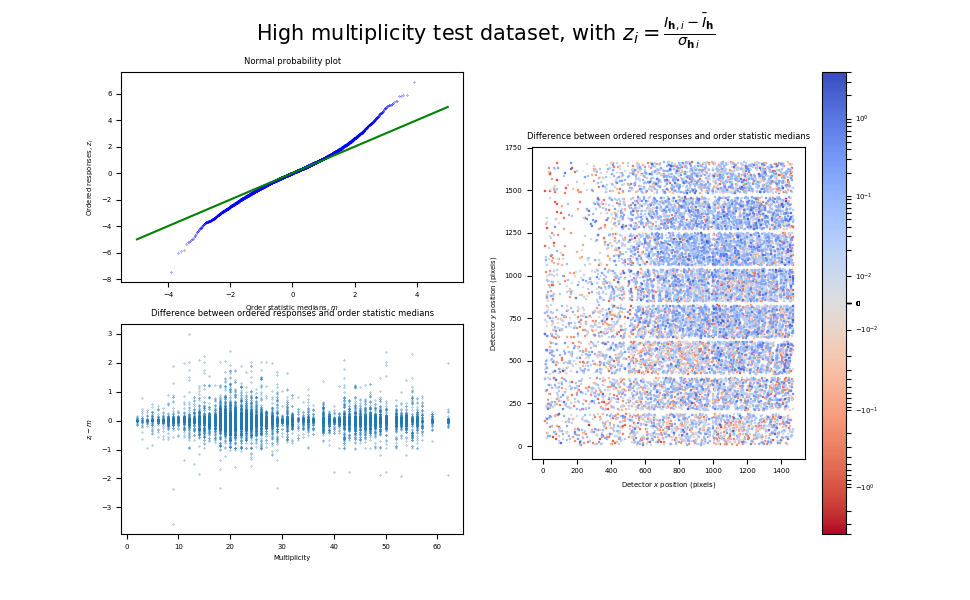

In [21]:
osm, osr, order, fig = probplots(I, Imeans, sigI, multis, x, y)
fig.suptitle(
  r'High multiplicity test dataset, with $z_i = \frac{I_{\mathbf{h}, i} - \bar{I}_\mathbf{h}}{\sigma_{\mathbf{h}\,i}}$',
  fontsize = 15,
)
plt.show()

As expected, the powder-like ring is gone.

#### Low-multiplicity test case

Let's see if it works as well for our low-multiplicity data.  We spoof `sys.argv` again.

In [22]:
sys.argv.pop()
sys.argv.append('AUTOMATIC_DEFAULT_scaled_unmerged.mtz')
print(sys.argv)

['/home/ekm22040/DIALS/base/lib/python2.7/site-packages/ipykernel_launcher.py', 'AUTOMATIC_DEFAULT_scaled_unmerged.mtz']


And now we need to read in the data, select out the multiplicity-1 data...

In [23]:
ind, I, sigI, x, y = data_from_unmerged_mtz(
  sys.argv[1] # Give an unmerged MTZ file as an argument.
)

#plot_time_series(ind, ind_unique, I, sigI)
#plt.show()

ind_unique, multis, Imeans, sImeans, stddevs = mean_error_stddev(
  ind, I, sigI
)

#plot_time_series(ind, ind_unique, I, sigI, overlay=(Imeans, stddevs))
#plt.show()  

# Select out multiplicity-1 data:
sel = (multis > 1).iselection()
I, sigI, Imeans, stddevs, sImeans, multis, x, y = map(
  lambda x: x.select(sel),
  (I, sigI, Imeans, stddevs, sImeans, multis, x, y)
)

... and plot.

<IPython.core.display.Javascript object>


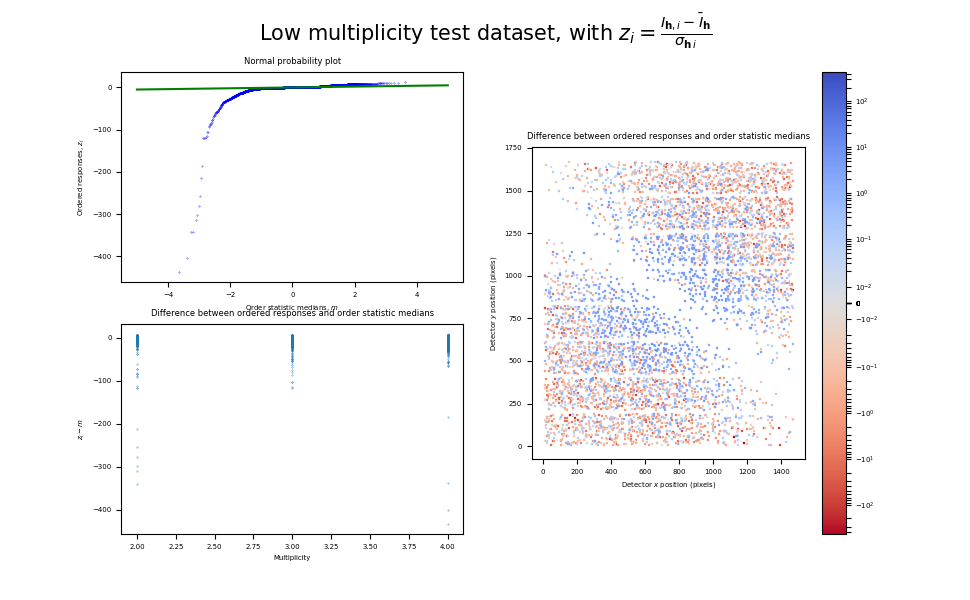

In [26]:
osm, osr, order, fig = probplots(I, Imeans, sigI, multis, x, y)
fig.suptitle(
  r'Low multiplicity test dataset, with $z_i = \frac{I_{\mathbf{h}, i} - \bar{I}_\mathbf{h}}{\sigma_{\mathbf{h}\,i}}$',
  fontsize = 15,
)
plt.show()

Hmm... let's zoom in a bit on the centre of that normal probability plot.

<IPython.core.display.Javascript object>


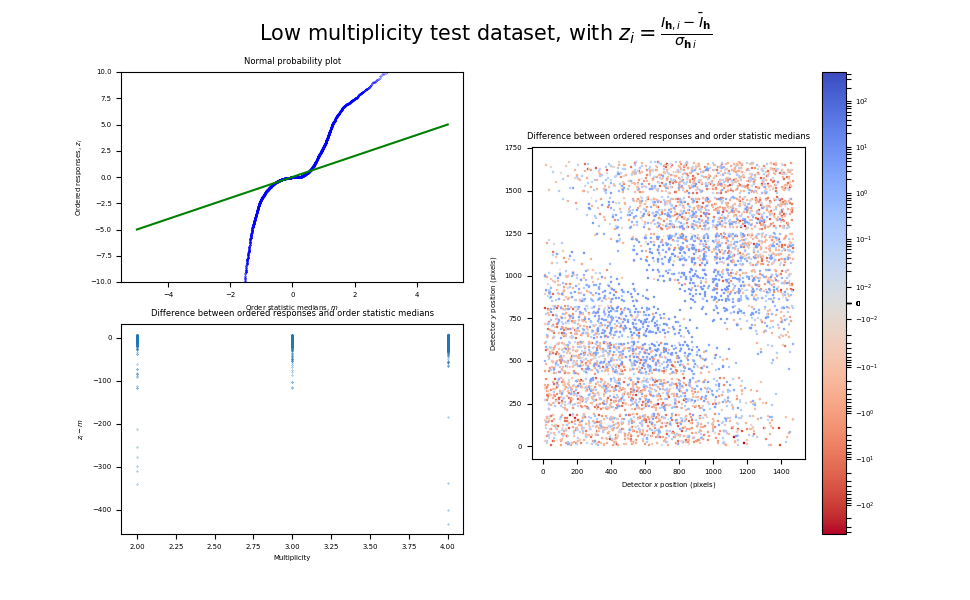

In [27]:
osm, osr, order, fig = probplots(I, Imeans, sigI, multis, x, y)
fig.suptitle(
  r'Low multiplicity test dataset, with $z_i = \frac{I_{\mathbf{h}, i} - \bar{I}_\mathbf{h}}{\sigma_{\mathbf{h}\,i}}$',
  fontsize = 15,
)
fig.get_axes()[0].set_ylim(-10,10)
plt.show()

Still rather dodgy-looking, if you ask me.  Am I using a dodgy dataset to illustrate low-multiplicity behaviour, or are my calculations at fault?

## Conclusions so-far

It seems that by using the weighted merged variance in calculating a sample standard deviation to use in calculating $z_i$, we may have been introducing two problems,
1. The averaging may have been masking extremal deviation from normality (we couldn't see the ring of extremal deviation before);
2. For low multiplicity datasets, small fluctuations in $\sigma_{\mathbf{h}\,i}$ were being amplified in $s_\mathbf{h}$, so that's no good.

However, even when simply using $\sigma_{\mathbf{h}\,i}$ in calculating $z_i$, the low multiplicity data look problematic...